In [1]:
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = ['next', 'prev', 'idel']

data = np.concatenate([
    np.load('dataset/seq_next_1714367781.npy'),
    np.load('dataset/seq_prev_1714367781.npy'),
    np.load('dataset/seq_idel_1714367781.npy')
], axis=0)

data.shape

(1080, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(1080, 30, 99)
(1080,)


In [4]:
from tensorflow.keras.utils import to_categorical

# 데이터 타입 변경 및 레이블 원-핫 인코딩
x_data = x_data.astype(np.float32)
y_data = to_categorical(labels, num_classes=len(actions))

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)


In [5]:
# 모델 구성
model = Sequential([
    LSTM(512, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Flatten(),
    Dense(len(actions), activation='softmax')
])

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# ReduceLROnPlateau 콜백 조정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='min', min_lr=0.00001)

# ModelCheckpoint 콜백 조정
model_checkpoint = ModelCheckpoint('models/updated_model_2.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')


# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 콜백 정의
# callbacks = [
#     ModelCheckpoint('models/updated_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'),
#     ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=50, verbose=1)
# ]

# 모델 요약
model.summary()

c:\Users\SSAFY\Desktop\gesture-recognition\py3.9\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 512)        │     1,253,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30, 1024)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │        23,043 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,129,923 (8.13 MB)

 Trainable params: 2,129,923 (8.13 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 모델 학습
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/200
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7839 - loss: 0.4734
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to models/updated_model_2.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7919 - loss: 0.4572 - val_accuracy: 1.0000 - val_loss: 6.9278e-05 - learning_rate: 0.0010
Epoch 2/200
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9974 - loss: 0.0045
Epoch 2: val_accuracy did not improve from 1.00000
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9975 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 6.7968e-06 - learning_rate: 0.0010
Epoch 3/200
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6601e-05
Epoch 3: val_accuracy did not improve from 1.00000
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - loss: 2.6500e-05 - val_accuracy: 1.0000 - val_loss: 4.3941e-06 - learning_rate: 0.0010
Epoch 4/200
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.6863e-06
Epoch 4: val

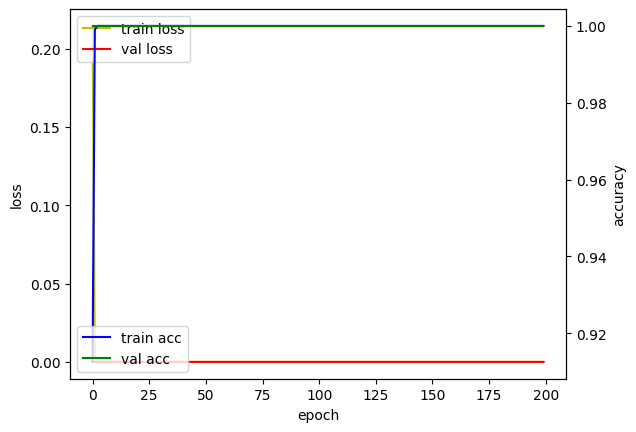

In [8]:
# 학습 결과 시각화
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()